# Principais Bibliotecas

In [3]:
import cv2
import cvzone
import numpy as np
import matplotlib.pyplot as plt
from cvzone.FaceMeshModule import FaceMeshDetector
from cvzone.PlotModule import LivePlot
from pynput.keyboard import Key, Controller

# Printando todos os pontos faciais 

E:\Desktop\Documentos de aulas\iris_detection\iris_detection\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


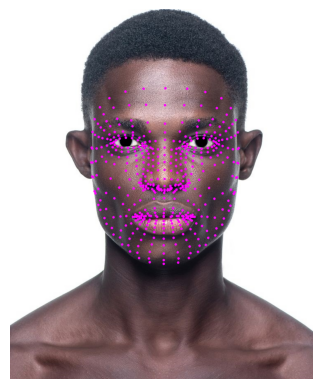

In [4]:
detector = FaceMeshDetector(maxFaces=1)

img_face = cv2.imread("face.jpg", cv2.IMREAD_COLOR)

img_face_rgb = cv2.cvtColor(img_face, cv2.COLOR_BGR2RGB)

frame, faces = detector.findFaceMesh(img_face, draw=False)

if faces:
    face = faces[0]
    for i in range(len(face)):  
        cv2.circle(frame, face[i], 3, (255, 0, 255), cv2.FILLED)

output_path = "mesh_points.jpg"
cv2.imwrite(output_path, frame)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.axis('off')  
plt.show()

# Printando os pontos das imagens e colocando os index de cada ponto (imagem 8k) 

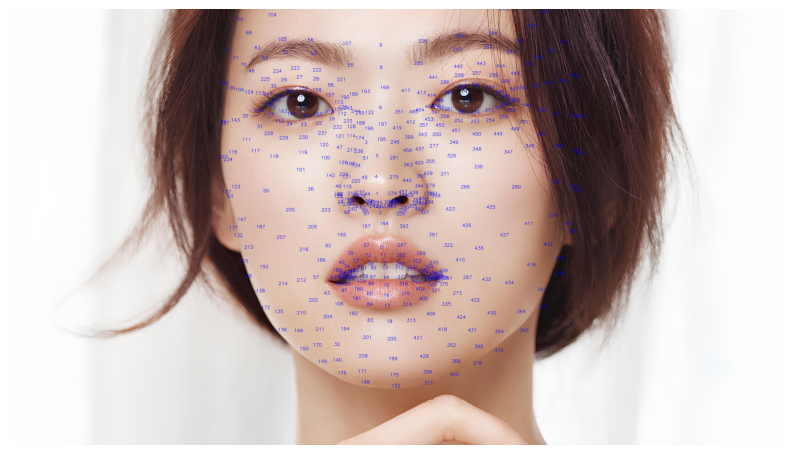

In [21]:
image_path = "8k.jpg"  
img_face = cv2.imread(image_path)

frame, faces = detector.findFaceMesh(img_face, draw=False)

if faces:
    face_points = faces[0]
    
    for idx, point in enumerate(face_points):
        x, y = point
        cv2.circle(frame, (x, y), 2, (0, 255, 0), cv2.FILLED)
        cv2.putText(frame, str(idx), (x + 5, y + 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 2)
        
output_path = "mesh_indexes.jpg"
cv2.imwrite(output_path, frame)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(frame_rgb)
plt.axis('off')  
plt.show()

# Detecção de Iris


## Função para detectar iris 

In [22]:
def detectIris(frame, eyeLandmarks, face, minValue):
    eyePoints = np.array([face[i] for i in eyeLandmarks])
    
    # Determinar a região de interesse (ROI) ao redor do olho
    x, y, w, h = cv2.boundingRect(eyePoints)
    eyeROI = frame[y:y+h, x:x+w]

    # Converter para escala de cinza
    grayROI = cv2.cvtColor(eyeROI, cv2.COLOR_BGR2GRAY)

    # Suaviza para reduzir ruído
    blurredROI = cv2.GaussianBlur(grayROI, (9, 9), 2)

    # Limita valores brilhantes para remover reflexos (segmenta)
    _, binaryROI = cv2.threshold(blurredROI, minValue, 255, cv2.THRESH_BINARY_INV)

    # Realiza operações morfológicas para remover ruídos menores
    kernel = np.ones((3, 3), np.uint8)
    cleanedROI = cv2.morphologyEx(binaryROI, cv2.MORPH_CLOSE, kernel)

    # Encontrar contornos na ROI
    contours, _ = cv2.findContours(cleanedROI, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Identificar o maior contorno (possivelmente a íris)
    if contours:
        largestContour = max(contours, key=cv2.contourArea)
        ((cx, cy), radius) = cv2.minEnclosingCircle(largestContour)
        
        # Ajustar coordenadas da ROI para a imagem inteira
        center = (int(cx) + x, int(cy) + y)
        radius = int(radius) 
        
        cv2.circle(frame, center, radius, (0, 255, 0), 2)
        cv2.circle(frame, center, 2, (0, 0, 255), 3)  # Centro da íris
    
    return frame

## Detecção em imagem parada

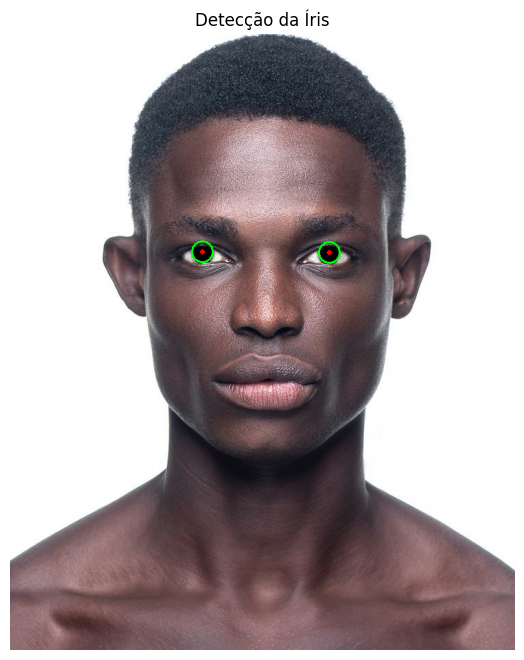

In [24]:
leftEyeLandmarks = [7, 33, 145, 144, 153, 154, 155, 157, 158, 159, 160, 161, 173, 246]
rightEyeLandmarks = [249, 263, 362, 373, 374, 380, 381, 382, 384, 385, 386, 387, 388, 390, 398, 466]

imagePath = "face.jpg"  
frame = cv2.imread(imagePath)

if frame is None:
    print("Erro ao carregar a imagem.")
    exit()

frame, faces = detector.findFaceMesh(frame, draw=False)

if faces:
    face = faces[0]

    frame = detectIris(frame, leftEyeLandmarks, face, 35)
    frame = detectIris(frame, rightEyeLandmarks, face, 35)
else:
    print("Nenhum rosto detectado.")

frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
output_path = "iris_detectada.jpg"

cv2.imwrite(output_path, frame)
plt.figure(figsize=(10, 8))
plt.imshow(frameRGB)
plt.axis("off")  
plt.title("Detecção da Íris")
plt.show()

## Detecção na Webam


In [14]:
cap = cv2.VideoCapture(0)  

if not cap.isOpened():
    print("Erro ao abrir a webcam.")
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        print("Erro ao capturar o frame.")
        break

    frame, faces = detector.findFaceMesh(frame, draw=False)

    if faces:
        face = faces[0]

        frame = detectIris(frame, leftEyeLandmarks, face, 100)
        frame = detectIris(frame, rightEyeLandmarks, face, 100)
    
    cv2.imshow("Detecção da Íris", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

***

# Código de referência e inspiração do Ardens (Youtube) 
#### https://www.youtube.com/watch?v=G1s2Sg-AJ0E&ab_channel=Ardens
#### https://github.com/myNameIsArdens/BlinkDetection2.0/blob/main/blink2.0.py

In [15]:
keyboard = Controller()

cap = cv2.VideoCapture(0)

leftEyeLandmarks = [22, 23, 24, 26, 110, 157, 158, 159, 160, 161, 130, 243]

plotY = LivePlot(640, 360, [0, 40], invert=True)

while True:
    # Capturing frame
    retval, frame = cap.read()

    # Exit the application if frame not found
    if not retval:
        break

    # Getting face recognition mesh      
    frame, faces = detector.findFaceMesh(frame, draw=False)

    if faces:
        face = faces[0]
        # Draws every landmark on the left eye
        for i in leftEyeLandmarks:
            cv2.circle(frame, face[i], 1, (255, 0, 255), cv2.FILLED)

        # Vertical and Horizontal keypoints
        topEyelid = face[159]
        bottomEyelid = face[23]
        leftCorner = face[130]
        rightCorner = face[243]

        # Vertical distance
        lengthVer, _ = detector.findDistance(topEyelid, bottomEyelid)

        # Horizontal distance
        lengthHor, _ = detector.findDistance(leftCorner, rightCorner)

        # Draws the vertical line
        cv2.line(frame, topEyelid, bottomEyelid, (0, 200, 0), 1)


        # Blinking ratio
        ratio = int((lengthVer / lengthHor) * 100)
        
        # If the eyelids are closed, press the spacebar
        if ratio < 30:
            keyboard.press(Key.space)
        # If the eyelids are open, release the spacebar                   
        if ratio > 30:
            keyboard.release(Key.space)

            # Shows the frame and the plot on top of each other
        imgPlot = plotY.update(ratio)
        frame = cv2.resize(frame, (640, 480))
        frameStack = cvzone.stackImages([frame, imgPlot], 1, 1)

    else:
        # Only draw the frames
        frame = cv2.resize(frame, (640, 480))
        frameStack = cvzone.stackImages([frame, frame], 1, 1)

    # Opens video captured window
    cv2.imshow("BlinkDetection2.0", frameStack)

    # WaitKey(1) will wait for a keyPress for just 1 milliseconds and it will
    # continue to refresh and read frame from your webcam using cap.read().
    key = cv2.waitKey(1)

    # If the escape key is pressed, close the application 
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()